### Librairies Needed

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from datetime import date
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Heston Model Implementation 

In [44]:
def get_initial_asset_price():
    while True:
        S = input('Enter the initial asset price : ')
        try:
            initial_asset_price = int(S)
            return initial_asset_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_initial_volatility():
    while True:
        vol = input('Enter the Volatility (between 0 and 1) : ')
        try:
            volatility = float(vol)
            if 0 <= volatility <= 1:
                return volatility
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_long_term_variance():
    while True:
        var_long = input('Enter the Long Term Variance (between 0 and 1) : ')
        try:
            var_long_term = float(var_long)
            if 0 <= var_long_term <= 1:
                return var_long_term
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")
            
def get_rate_of_reversion():
    while True:
        rate = input('Enter the rate of reversion of variance (between 0 and 10): ')
        try:
            rate_of_reversion = int(rate)
            if 0 <= rate_of_reversion <= 10:
                return rate_of_reversion
            else:
                print("Invalid value. Please enter a number between 0 and 10.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 10.")

def get_vol_of_vol():
    while True:
        v_o_v = input('Enter the Volatility of Volatility (between 0 and 1): ')
        try:
            vol_of_vol = float(v_o_v)
            if 0 <= vol_of_vol <= 1:
                return vol_of_vol
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_correlation():
    while True:
        cor = input('Enter the correlation between the two processes (between -1 and 1): ')
        try:
            correlation = float(cor)
            if -1 <= correlation <= 1:
                return correlation
            else:
                print("Invalid value. Please enter a number between 1 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between ;1 and 1.")

def get_rf():
    while True:
        rate = input('Enter the Risk-Free rate (between 0 and 1): ')
        try:
            rate = float(rate)
            if 0 <= rate <= 1:
                return rate
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_maturity():
    while True:
        M = input('Enter the Maturity (in years): ')
        try:
            maturity = float(M)
            if maturity > 0:
                return maturity
            else:
                print("Invalid value. Please enter a positive number.")
        except ValueError:
            print("Invalid number type. Please enter a valid number.")

def get_time_step():
    while True:
        steps = input('Enter the number of time steps (between 0 and 1000): ')
        try:
            steps = int(steps)
            if 0 <= steps <= 1000:
                return steps
            else:
                print("Invalid value. Please enter a number between 0 and 1000.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 1000.")
    
def get_paths():
    while True:
        paths = input('Enter the number of paths (between 0 and 10000): ')
        try:
            paths = int(paths)
            if 0 <= paths <= 10000:
                return paths
            else:
                print("Invalid value. Please enter a number between 0 and 10000.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 10000.")

In [45]:
S0 = get_initial_asset_price()  
v0 = get_initial_volatility()      
theta = get_long_term_variance()   
kappa = get_rate_of_reversion()  
sigma_v = get_vol_of_vol()  
rho = get_correlation()     
r = get_rf()       
T = get_maturity()        
N = get_time_step()      
M = get_paths()  
dt=T/N   

In [46]:
print("Parameter Values:")
print("---------------------------------------")
print(f"Initial Asset Price (S0):     {S0} $")
print(f"Initial Volatility (v0):      {v0*100} %")
print(f"Long-term Variance (theta):   {theta*100} %")
print(f"Rate of Reversion (kappa):    {kappa}")
print(f"Volatility of Volatility:     {sigma_v*100} %")
print(f"Correlation (rho):            {rho}")
print(f"Risk-free Interest Rate (r):  {r*100} %")
print(f"Maturity (T):                 {T} years")
print(f"Number of Time Steps (N):     {N}")
print(f"Number of Paths (M):          {M}")
print("---------------------------------------")

Parameter Values:
---------------------------------------
Initial Asset Price (S0):     100 $
Initial Volatility (v0):      4.0 %
Long-term Variance (theta):   4.0 %
Rate of Reversion (kappa):    2
Volatility of Volatility:     30.0 %
Correlation (rho):            -0.7
Risk-free Interest Rate (r):  5.0 %
Maturity (T):                 1.0 years
Number of Time Steps (N):     1000
Number of Paths (M):          10000
---------------------------------------


# Methods Implementation for Price and Volatility Predictions

<ins>Generation of Winer processes.</ins>

To generate Wiener processes we need to use the <ins>Euler Scheme.
</ins>

The Euler Scheme is a numerical method for solving stochastic differential equations, it is a discrete approximation of the solution of a stochastic differential equation.

The stochastic differential equation for the asset price $ S_t $ in the Heston model is:

$$
\boxed{dS_t = \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S}
$$

And the stochastic differential equation for the variance $ v_t $ (volatility) is:

$$ 
\boxed{dv_t = \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v}
$$


All parameters are detailed in the Readme.

<br/>

The Euler Scheme is construct like that :

$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + (r - \frac{1}{2}\hat{V}(t)^+)  \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta}
$$

$$
\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}
$$

In these formulas we got $\hat{V}(t)^+$ because with the basic Euler Scheme , an immediate problem is that the discrete process for $V$ can become negative with non-zero probability, which in turn would make computation of $\sqrt{\hat{V}(t)}$ impossible and cause the time-stepping scheme to fail.

We got : 

$$
Z_V = \Phi^{-1}(U_1)
$$
and 
$$
Z_X = \rho Z_V + \sqrt{1 - \rho^2} \Phi^{-1}(U_2)
$$

with $U_1$ and $U_2$ $\sim U(0, 1)$ .

<br/>

For us $Z_V$ will be $W1$ and $Z_X$ will be $W2$ in all the project.

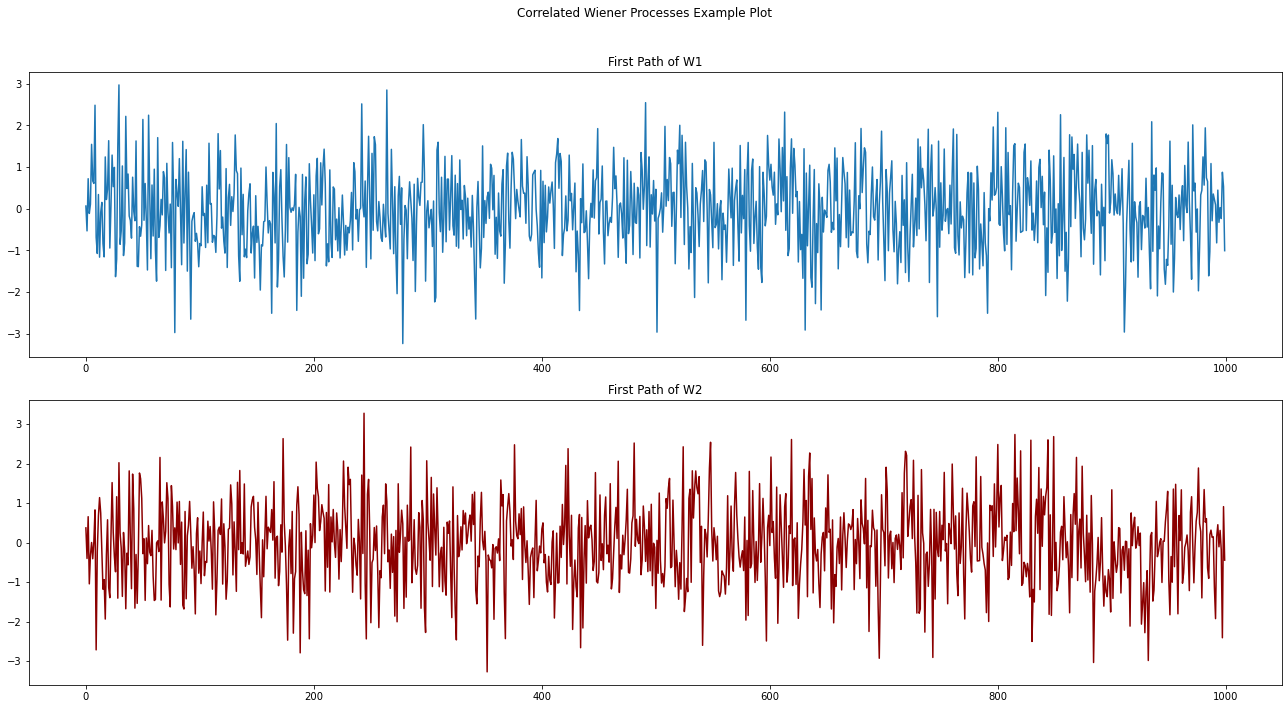

In [53]:
def generate_Wiener_correlated(time_step,paths,cor) : 
    """
    Generates two correlated Wiener processes.

    Parameters:
    - T (float): Total time (or maturity) of the process.
    - time_step (int): Number of time steps.
    - paths (int): Number of paths (simulations).
    - cor (float): Desired correlation coefficient between W1 and W2.

    Returns:
    - W1 (ndarray): Array of shape (time_step, paths) containing increments of the first Wiener process.
    - W2 (ndarray): Array of shape (time_step, paths) containing increments of the second Wiener process,
                    adjusted to have correlation 'cor' with W1.
    """
    W1=np.random.randn(time_step,paths)
    # W2=np.random.randn(time_step,paths) It's not good to do this because W1 and W2 will not be correlated
    W2=cor*W1+np.sqrt(1-cor**2)*np.random.randn(time_step,paths)
    return W1,W2

W1,W2=generate_Wiener_correlated(N,M,rho)


fig, ax = plt.subplots(2, 1, figsize=(18, 10))  
ax[0].plot(W1[:, 0]) 
ax[0].set_title('First Path of W1')

ax[1].plot(W2[:, 0],color='darkred')  
ax[1].set_title('First Path of W2')

fig.suptitle('Correlated Wiener Processes Example Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

We got that from Euler Scheme : 

The Euler Scheme is construct like that :


$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + (r - \frac{1}{2} \hat{V}(t)^+) \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta}
$$

$$
\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}
$$

This implies that  : 

$$
\boxed{\hat{X}(t + \Delta) = \hat{X}(t) * \exp ((r - \frac{1}{2} \hat{V}(t)^+) \Delta + \sqrt{\hat{V}(t)^+ } Z_X \sqrt{\Delta})}
$$

$$
\boxed{\hat{V}(t + \Delta) = \hat{V}(t) + \kappa (\theta - \hat{V}(t)^+ ) \Delta + \epsilon \sqrt{\hat{V}(t)^+ } Z_V \sqrt{\Delta}}
$$

In [6]:
def Euler_Scheme_Heston_Model(W1,W2,kappa,theta,dt,sigma_v,N,M,Price,volatility) : 
    for i in range(1, N):
        volatility[i] = volatility[i-1] + kappa * (theta - volatility[i-1]) * dt + sigma_v * np.sqrt(np.maximum(volatility[i-1], 0) * dt) * W1[i-1]
        Price[i] = Price[i-1] * np.exp((r - 0.5 * volatility[i-1]) * dt + np.sqrt(np.maximum(volatility[i-1], 0) * dt) * W2[i-1])
    return Price,volatility

It exists others scheme to compute prices and volatility predictions.

One of them is the <ins>Kahl-Jackel Scheme </ins> which is construct like that : 

$$
\ln \hat{X}(t + \Delta) = \ln \hat{X}(t) + \frac{\Delta}{4} (\hat{V}(t+\Delta) + \hat{V}(t)) + \rho \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{2} (\sqrt {\hat{V}(t+\Delta)}+ \sqrt{\hat{V}(t)})(Z_X\sqrt{\Delta}-\rho Z_V \sqrt{\Delta})+\frac{1}{4} \epsilon \rho \Delta (Z_V^2 -1)
$$

$$
\hat{V}(t + \Delta) = \frac{\hat{V}(t) + \kappa \theta \Delta + \epsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{4} \epsilon ^2 \Delta (Z_V^2 -1)}{1+ \kappa \Delta}
$$

If we want $\hat{X}(t + \Delta)$ and not $\ln \hat{X}(t + \Delta)$ we need to apply (like we did to Euler formulas) an $\exp$. 

By applying this, the formulas became : 

$$
\boxed{\hat{X}(t + \Delta) = \hat{X}(t) * \exp (\frac{\Delta}{4} (\hat{V}(t+\Delta) + \hat{V}(t)) + \rho \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{2} (\sqrt {\hat{V}(t+\Delta)}+ \sqrt{\hat{V}(t)})(Z_X\sqrt{\Delta}-\rho Z_V \sqrt{\Delta})+\frac{1}{4} \epsilon \rho \Delta (Z_V^2 -1)) }
$$

$$
\boxed{\hat{V}(t + \Delta) = \frac{\hat{V}(t) + \kappa \theta \Delta + \epsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta} + \frac{1}{4} \epsilon ^2 \Delta (Z_V^2 -1)}{1+ \kappa \Delta}}
$$


In [111]:
def  Kahl_Jackel_Scheme_Heston_Model(W1,W2,kappa,theta,dt,rho,sigma_v,N,M,Price,volatility) : 
    sqrt_dt = np.sqrt(dt)
    for i in range(1, N):
        value_vol=(volatility[i-1] + (kappa * theta * dt) + (sigma_v * np.sqrt(volatility[i-1] * dt) * W1[i-1]) + ((1/4) * sigma_v**2 * dt *(W1[i-1]**2 - 1)))/(1+kappa*dt)
        volatility[i] = value_vol
        vol_term = np.sqrt(value_vol + volatility[i-1])        
        term1 = (dt / 4) * (value_vol + volatility[i-1])
        term2 = rho * np.sqrt(volatility[i-1] * dt) * W1[i-1]
        term3 = 0.5 * (np.sqrt(value_vol) + vol_term) * ((W2[i-1] * sqrt_dt) - (rho * W1[i-1] * sqrt_dt))
        term4 = 0.25 * sigma_v * rho * dt * (W1[i-1]**2 - 1)
        
        Price[i] = Price[i-1] * np.exp(-term1 + term2 - term3 + term4)
    return Price,volatility

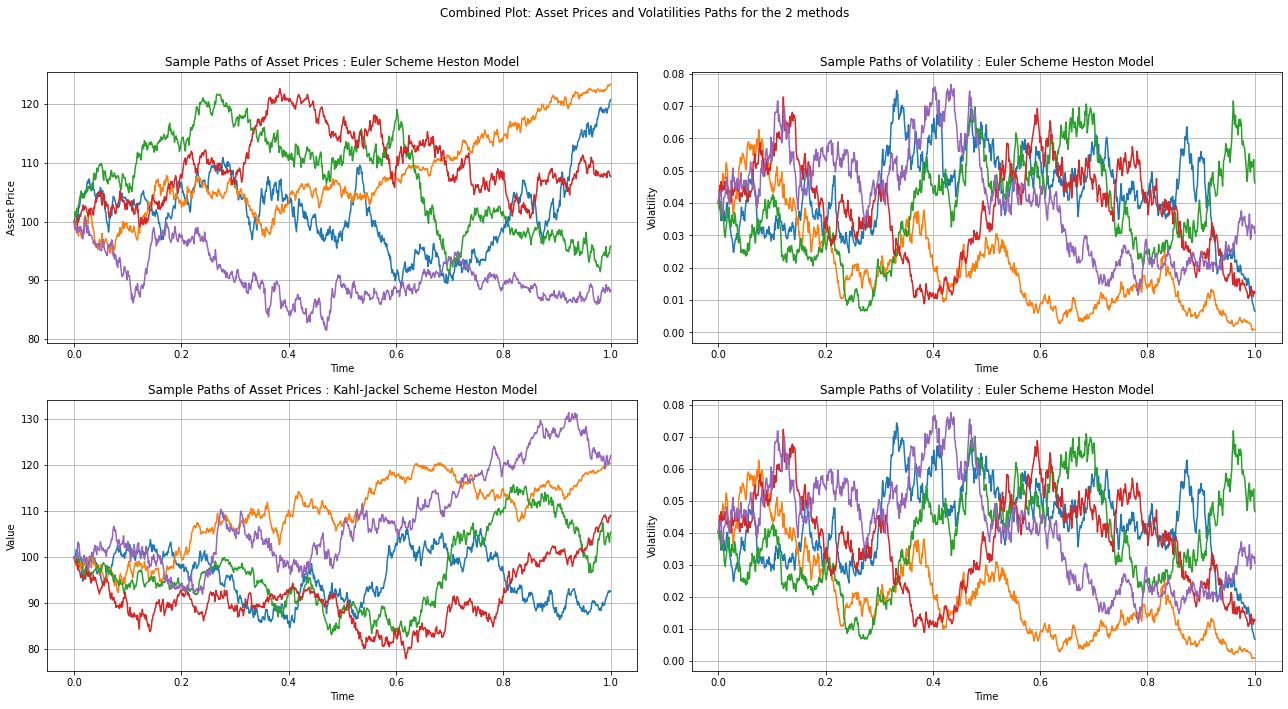

In [81]:
S_euler = np.zeros((N, M))
v_euler = np.zeros((N, M))
S_Kahl = np.zeros((N, M))
v_Kahl = np.zeros((N, M))

S_euler[0] = S0
v_euler[0] = v0
S_Kahl[0] = S0
v_Kahl[0] = v0

S_euler,v_euler=Euler_Scheme_Heston_Model(W1,W2,kappa,theta,dt,sigma_v,N,M,S_euler,v_euler)
S_Kahl,v_Kahl=Kahl_Jackel_Scheme_Heston_Model(W1,W2,kappa,theta,dt,rho,sigma_v,N,M,S_Kahl,v_Kahl)

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

for i in range(5):
    ax[0,0].plot(np.linspace(0, T, N), S_euler[:, i])
    ax[1,0].plot(np.linspace(0, T, N), S_Kahl[:, i])
    ax[0,1].plot(np.linspace(0, T, N), v_euler[:, i])
    ax[1,1].plot(np.linspace(0, T, N), v_Kahl[:, i]) 

ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Asset Price')
ax[0,0].set_title('Sample Paths of Asset Prices : Euler Scheme Heston Model')
ax[0,0].grid(True)    

ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Value')
ax[1,0].set_title('Sample Paths of Asset Prices : Kahl-Jackel Scheme Heston Model')
ax[1,0].grid(True)

ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Volatility')
ax[0,1].set_title('Sample Paths of Volatility : Euler Scheme Heston Model')
ax[0,1].grid(True)    

ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Volatility')
ax[1,1].set_title('Sample Paths of Volatility : Euler Scheme Heston Model')
ax[1,1].grid(True)    


fig.suptitle('Combined Plot: Asset Prices and Volatilities Paths for the 2 methods')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Characteristic function of the Heston Model

By working on the Heston model characteristic function formula, we get that : 

$$
\boxed{\phi (u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0) = \mathbb E [\exp(iu \ln(S_T))] }
$$

To get the final forme of $\phi$ we need severals deviation steps : 

$$\ln(S_T) = \ln(S_0) + \int_{0}^{T} (r - \frac{1}{2}v(t)) dt + \int_{0}^{T} (\sqrt{v(t)}dW_S(t))$$

Apply Itô's lemma to the logarithm of the asset price to derive the stochastic differential equation (SDE) for $\ln(S_T)$

$$d\ln(S_T) = (r - \frac{1}{2}v(t)) dt + \sqrt{v(t)}dW_S(t)$$

Condition on the initial variance $v_0$ and derive the characteristic function $\phi$ as the expected value of $\exp(iu\ln(S_T))$ under the Heston model dynamics : 

$$\boxed{\phi (u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0) = \exp(C(u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)+D(u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)v_0 + i u \log (S_0))}$$

 where : 
 - $u$ is the intergation variable 
 - $S_0$ is the initial stock price 
 - $K$ is the Strike price 
 - $r$ is the risk-free interest rate 
 - $T$ is the Time to maturitity 
 - $rk$ is the mean reversion rate 
 - $\theta$ is the long-term average volatility 
 - $\sigma$ is the volatility 
 - $\rho$ is the correlation coefficient between the asset price and its volatility 
 - $v_0$ is the initial volatility

</br>

Definition : 

$C(u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)$ represent the <ins>real</ins> part of the logarithm of the characteristic function $\phi (u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)$

Formula : $$\boxed{C=r*iu*T* \frac{\kappa \theta}{\sigma^2} [(x - \rho \sigma iu - d)T - 2* \ln(\frac{1-g\exp(-dT)}{1-g})]}$$

- $iu$ is the imaginary unit multiplied by $u$

- $x = \kappa - \rho \sigma iu$

- $d = \sqrt{(\rho \sigma iu - x)^2 + \sigma^2 (-ui - u^2)}$

- $g = \frac{x - \rho \sigma iu - d}{x - \rho \sigma iu + d}$

$D(u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)$ represent the <ins>imaginary</ins> part of the logarithm of the characteristic function $\phi (u,S_0,K,r,T,k,\theta,\sigma,\rho,v_0)$

Formula : $$\boxed{D=(x \rho \sigma iu - d) * \frac{1-g \exp(-dT)}{\sigma^2 (1-\exp(-dT))}}$$


In [8]:
def characteristic_heston_function(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
    xi = kappa - rho * sigma * 1j * u
    d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
    g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
    C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
    return np.exp(C + D * v0 + 1j * u * np.log(S0))

# European Option pricing with Heston model

Fourier inversion is employed to calculate option prices, particularly in models such as the Heston model. In this framework, the characteristic function plays a crucial role in pricing options through Fourier inversion.

To price a European call option using Fourier inversion, one integrates the characteristic function over a range of frequencies (or values of the integration variable $u$) to determine the option price.

Call Formula : 

$$
\boxed{C = e^{-rT} \left( \frac{1}{2} S_0 - \frac{1}{\pi} \int_{0}^{\infty} \frac{e^{-iu \ln(K)} \phi(u)}{iu} du \right)
}
$$

Put Formula : 

$$
\boxed{P = e^{-rT} \left( \frac{1}{\pi} \int_{0}^{\infty} \frac{e^{-iu \ln(K)} \phi(u)}{iu} du \right) - S_0 + K e^{-rT}}
$$

where :

- $C$ European call option price

- $P$ European put option price

- $K$ Strike price

- $S_0$ risk-free interest rate

- $T$ Time to maturitity

- $r$ mean reversion rate

- $\phi(u)$ Characteristic function of the Heston model

- $e^{-iu \ln(K)}$ Exponential term in the integrand

- $du$ Integration variable

- $\pi$ Approximately equal to $3.14159$

In [9]:
def european_option_price(S0, K, r, T, kappa, theta, sigma, rho, v0,option_type,upper_limit=500):
    integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * characteristic_heston_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
    integral, _ = quad(integrand, 0, upper_limit)

    if option_type == 'Call':
        return np.exp(-r * T) * (0.5 * S0 - (1 / np.pi) * integral)
    else:
        return np.exp(-r * T) * ((1 / np.pi) * integral) - S0 + K * np.exp(-r * T)

In [121]:
K=110

call_option_price = european_option_price(S0, K, r, T, kappa, theta, sigma_v, rho, v0,'Call')
put_option_price = european_option_price(S0, K, r, T, kappa, theta, sigma_v, rho, v0,'Put')

print(f"The price of the European Call option using the Heston model is: {call_option_price:.3f} $")
print(f"The price of the European Put option using the Heston model is: {put_option_price:.3f} $")

The price of the European Call option using the Heston model is: 39.876 $
The price of the European Put option using the Heston model is: 12.320 $


# Barrier Option Pricing with Heston Model

Barrier options are exotic options where the payoff depends on whether the price of the underlying asset reaches a predetermined barrier level at any time during the option's life.

It exists **4** types of Barrier Options : 

- <ins>Up-and-Out</ins> : This option terminates if the barrier (set above the initial underlying price) is breached.

- <ins>Up-and-In</ins> : This option activates if the barrier (set above the initial underlying price) is breached, behaving thereafter like a vanilla option.

- <ins>Down-and-Out</ins> : This option expires worthless if the barrier (set below the initial underlying price) is breached.

- <ins>Down-and-In</ins> : This option activates if the barrier (set below the initial underlying price) is breached, thereafter behaving like a vanilla option.

There is two possibilities, a Call or a Put option. The differences are the payoff and the sign inversion in prices. 

I will detailled payoff and price for the <ins>8 options</ins> with H the barrier price : 

| Option Type              | Payoff                                     | Price                                                                          |
|-------------------------:|-------------------------------------------|--------------------------------------------------------------------------------|
| Up-and-Out Call Option   | $Payoff = \max(S_T-K,0) \cdot I_{\max(S_T)<H}$ | $Price = \exp(-rT) [S_0 \mathbb{P}(S_T > H) - K \mathbb{P}(S_T > H)]$         |
| Up-and-In Call Option    | $Payoff = \max(S_T-K,0) \cdot I_{\max(S_T) \geq H}$ | $Price = \exp(-rT) [S_0 \mathbb{P}(S_T > H) - K \mathbb{P}(S_T > H)]$        |
| Down-and-Out Call Option | $Payoff = \max(S_T-K,0) \cdot I_{\min(S_T)>H}$ | $Price = \exp(-rT) [S_0 - K] \mathbb{P}(S_T > H)$                              |
| Down-and-In Call Option  | $Payoff = \max(S_T-K,0) \cdot I_{\min(S_T) \leq H}$ | $Price = \exp(-rT) [S_0 - K] \mathbb{P}(S_T > H)$                             |
| Up-and-Out Put Option    | $Payoff = \max(K-S_T,0) \cdot I_{\max(S_T)<H}$ | $Price = \exp(-rT) [K \mathbb{P}(S_T > H) - S_0 \mathbb{P}(S_T > H)]$         |
| Up-and-In Put Option     | $Payoff = \max(K-S_T,0) \cdot I_{\max(S_T) \geq H}$ | $Price = \exp(-rT) [K \mathbb{P}(S_T > H) - S_0 \mathbb{P}(S_T > H)]$        |
| Down-and-Out Put Option  | $Payoff = \max(K-S_T,0) \cdot I_{\min(S_T)>H}$ | $Price = \exp(-rT) [K - S_0] \mathbb{P}(S_T > H)$                              |
| Down-and-In Put Option   | $Payoff = \max(K-S_T,0) \cdot I_{\min(S_T) \leq H}$ | $Price = \exp(-rT) [K - S_0] \mathbb{P}(S_T > H)$                             |



In [10]:
def price_up_and_out_option_Heston(paths, K, r, T, H, option_type='UO-Call'):

    """
    Price an up-and-out option (both call and put) using the Heston model.
 
    Parameters:
    paths : ndarray [1000 paths][10000 steps]
        Asset prices prediction compute by Euler or Kahl construction method.
    K : float
        Strike price
    r : float
        Risk-Free rate
    T : float
        Maturity
    H : float
        Barrier level.
    option_type : str, optional
        Type of option. Default is 'Up-and-Out Call'.

    Returns:
    float
        Price of the up-and-out option.
    """

    ST=paths[:,-1]
    rate_actualisation=np.exp(-r*T)
    
    if option_type == 'UO-Call':
        knocked_out = np.any(paths > H, axis=1)
        payoff = np.maximum(ST - K, 0) * ~knocked_out
    elif option_type == 'UI-Call':
        knocked_in = np.any(paths >= H, axis=1)
        payoff = np.maximum(ST - K, 0) * knocked_in
    elif option_type == 'DO-Call':
        knocked_out = np.any(paths < H, axis=1)
        payoff = np.maximum(ST - K, 0) * ~knocked_out
    elif option_type == 'DI-Call':
        knocked_in = np.any(paths <= H, axis=1)
        payoff = np.maximum(ST - K, 0) * knocked_in
    elif option_type == 'UO-Put':
        knocked_out = np.any(paths > H, axis=1)
        payoff = np.maximum(K - ST, 0) * ~knocked_out
    elif option_type == 'UI-Put':
        knocked_in = np.any(paths >= H, axis=1)
        payoff = np.maximum(K - ST, 0) * knocked_in
    elif option_type == 'DO-Put':
        knocked_out = np.any(paths < H, axis=1)
        payoff = np.maximum(K - ST, 0) * ~knocked_out
    elif option_type == 'DI-Put':
        knocked_in = np.any(paths <= H, axis=1)
        payoff = np.maximum(K - ST, 0) * knocked_in
    else:
        raise ValueError("Option type must be one of 'UO-Call', 'UI-Call', 'DO-Call', 'DI-Call', 'UO-Put', 'UI-Put', 'DO-Put', 'DI-Put'.")
        
    expected_payoff = np.mean(payoff)
    option_price = rate_actualisation * expected_payoff
    return option_price

In [301]:
S_euler,v_euler=Euler_Scheme_Heston_Model(W1,W2,kappa,theta,dt,sigma_v,N,M,S_euler,v_euler)
H = 120
option_types=['UO-Call', 'UI-Call', 'DO-Call', 'DI-Call', 'UO-Put', 'UI-Put', 'DO-Put', 'DI-Put']
prices = []

for option_type in option_types:
    price = price_up_and_out_option_Heston(S_euler, K, r, T, H, option_type)
    prices.append(price)
    
    print(f"Barrier Option Type: \033[4m{option_type}\033[0m")
    print(f"Price: {price:.3f} $\n")


Barrier Option Type: UO-Call
Price: 0.000 $

Barrier Option Type: UI-Call
Price: 3.263 $

Barrier Option Type: DO-Call
Price: 0.000 $

Barrier Option Type: DI-Call
Price: 3.263 $

Barrier Option Type: UO-Put
Price: 0.679 $

Barrier Option Type: UI-Put
Price: 3.079 $

Barrier Option Type: DO-Put
Price: 0.000 $

Barrier Option Type: DI-Put
Price: 3.757 $



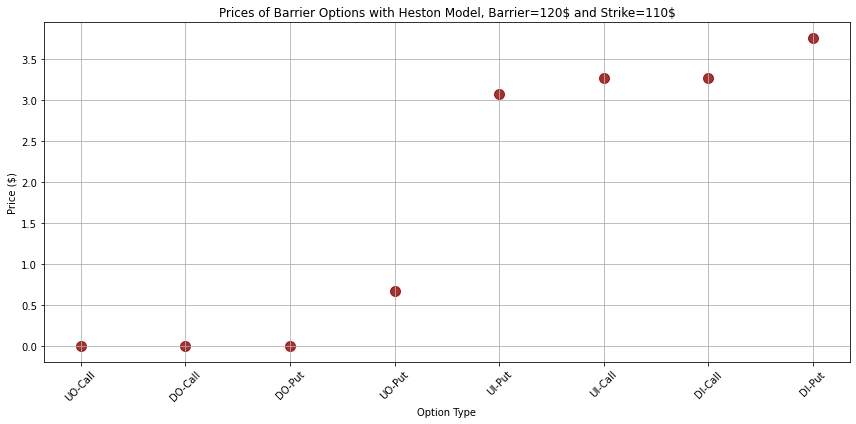

In [308]:
df = pd.DataFrame({
    'Option Type': option_types,
    'Price ($)': prices,
})

df_sorted = df.sort_values(by='Price ($)', ascending=True)
plt.figure(figsize=(12, 6))
plt.scatter(df_sorted['Option Type'], df_sorted['Price ($)'], color='darkred', marker='o', s=100, alpha=0.8)
plt.xlabel('Option Type')
plt.ylabel('Price ($)')
plt.title(f'Prices of Barrier Options with Heston Model, Barrier={H}\$ and Strike={K}\$')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Variance Swap Pricing with Heston Model

A variance swap is a financial derivative that allows investors to speculate on or hedge against the volatility of an underlying asset. 

From the simulated paths of the Heston model, we can compute the realized variance $RV$ over the life of the variance swap. This is typically the sum of squared returns of the asset price.

Calculate the expected payout of the variance swap : 

$$(RV-K)^+$$

At the end, we need to discount the expected payout to present value using the risk-free rate $r$ over the maturity $T$ of the variance swap.

In [274]:
def price_variance_swap_Heston(paths,N):
    returns = np.log(paths[1:] / paths[:-1])
    realized_variance = np.mean(np.square(returns), axis=0) * N
    swap_price = np.mean(realized_variance)
    return swap_price

In [275]:
variance_swap_price = np.mean(v_euler[1:N+1]) * T
var_swap_price=price_variance_swap_Heston(S_euler,N)

print(f"The price of the Variance Swap option using Volatilities of Heston model is: \033[4m{variance_swap_price:.3f}$\033[0m")
print(f"The price of the Variance Swap option using Prices of Heston model is: \033[4m{var_swap_price:.3f}$\033[0m")

The price of the Variance Swap option using Volatilities of Heston model is: 0.040$
The price of the Variance Swap option using Prices of Heston model is: 0.040$


# Monte-Carlo Simuation of a Stock with Heston Model

Now that we got the heuristic function of Heston formula we can use it to simulate the price and the volatility of a stock. To do that we gonna recup information on a stock and apply the Heston model to it. 

In [93]:
ticker = 'AAPL' 
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
data['Returns'] = data['Adj Close'].pct_change().dropna()

returns = data['Returns'].dropna()
volatility = returns.rolling(window=21).std().dropna()

theta = np.mean(volatility ** 2)

[*********************100%%**********************]  1 of 1 completed


In [105]:
volatility_shifted = volatility.shift(1).dropna()
volatility = volatility.loc[volatility_shifted.index]
X = volatility_shifted.values.reshape(-1, 1)
y = volatility.values
reg = LinearRegression().fit(X, y)
kappa = 1 - reg.coef_[0]
vol_changes = volatility.diff().dropna()
sigma_v = np.std(vol_changes)

rho, _ = pearsonr(returns.loc[volatility.index], volatility)

print(f'Estimated kappa: {kappa:.4f}')
print(f'Estimated theta: {theta:.4f}')
print(f'Estimated sigma_v: {sigma_v:.4f}')
print(f'Estimated rho: {rho:.4f}')

Estimated kappa: 0.0114
Estimated theta: 0.0006
Estimated sigma_v: 0.0015
Estimated rho: 0.0071


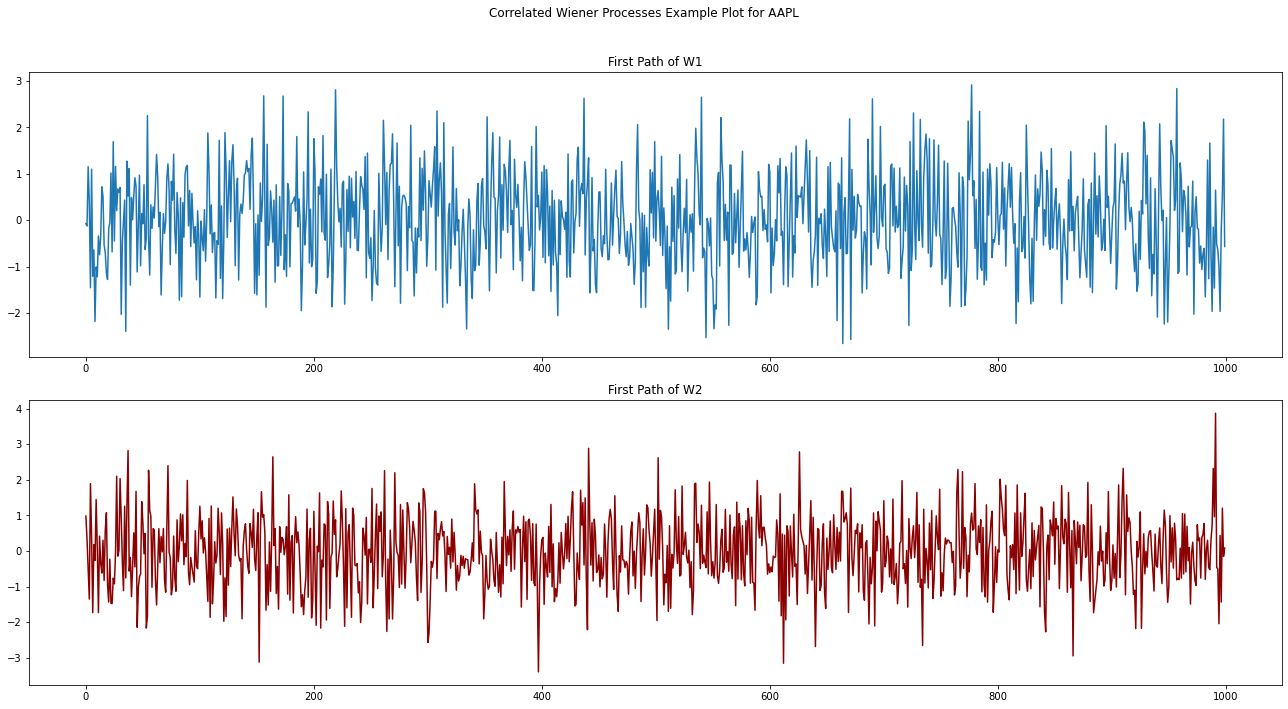

In [95]:
r = 0.05
T = 1.0
N = 1000
M = 10000
dt = T / N

W1,W2=generate_Wiener_correlated(N,M,rho)


fig, ax = plt.subplots(2, 1, figsize=(18, 10))  
ax[0].plot(W1[:, 0]) 
ax[0].set_title('First Path of W1')

ax[1].plot(W2[:, 0],color='darkred')  
ax[1].set_title('First Path of W2')

fig.suptitle(f'Correlated Wiener Processes Example Plot for {ticker}')
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


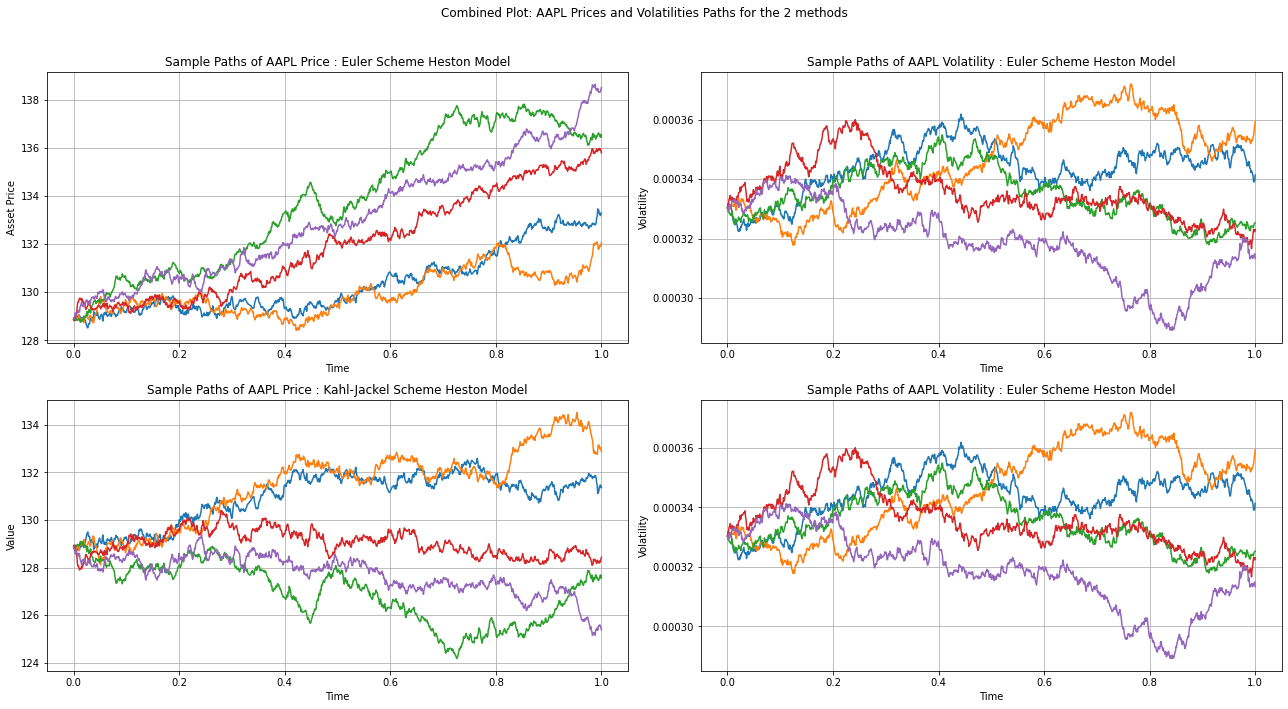

In [114]:
S0 = data['Adj Close'].iloc[-1]
v0 = volatility.iloc[-1] ** 2

Price_euler = np.zeros((N, M))
Price_Kahl = np.zeros((N, M))
volatility_euler = np.zeros((N, M))
volatility_Kahl = np.zeros((N, M))

Price_euler[0] = S0
volatility_euler[0] = v0
Price_Kahl[0] = S0
volatility_Kahl[0] = v0

Price_euler, volatility_euler = Euler_Scheme_Heston_Model(W1, W2, kappa, theta, dt, sigma_v, N, M, Price_euler, volatility_euler)
Price_Kahl, volatility_Kahl = Kahl_Jackel_Scheme_Heston_Model(W1, W2, kappa, theta, dt,rho, sigma_v, N, M, Price_Kahl, volatility_Kahl)

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

for i in range(5):
    ax[0,0].plot(np.linspace(0, T, N), Price_euler[:, i])
    ax[1,0].plot(np.linspace(0, T, N), Price_Kahl[:, i])
    ax[0,1].plot(np.linspace(0, T, N), volatility_euler[:, i])
    ax[1,1].plot(np.linspace(0, T, N), volatility_Kahl[:, i]) 

ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Asset Price')
ax[0,0].set_title(f'Sample Paths of {ticker} Price : Euler Scheme Heston Model')
ax[0,0].grid(True)    

ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Value')
ax[1,0].set_title(f'Sample Paths of {ticker} Price : Kahl-Jackel Scheme Heston Model')
ax[1,0].grid(True)

ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Volatility')
ax[0,1].set_title(f'Sample Paths of {ticker} Volatility : Euler Scheme Heston Model')
ax[0,1].grid(True)    

ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel(f'Volatility')
ax[1,1].set_title(f'Sample Paths of {ticker} Volatility : Euler Scheme Heston Model')
ax[1,1].grid(True)    


fig.suptitle(f'Combined Plot: {ticker} Prices and Volatilities Paths for the 2 methods')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Parameters Estimation using MLE

The purpose of this part is to estimating the parameters of the Heston model from historical market data which typically involves fitting the model to observed asset prices and their volatilities.

Maximum Likelihood Estimation (MLE) is commonly used for this purpose, though other statistical techniques like Bayesian estimation or method of moments can also be applied depending on the context and available data. 
 
I'm gonna use MLE to do this part.

The objectiv is to minimize the negative log_likelihood function, this will adjust the parameters : $\kappa$, $\theta$, $\rho$, $\sigma$, $v_0$ to best fit the observed data. 

The log-likelihood $\log L$ is the sum of the logarithms of the individual PDF values evaluated at each observed data point $x_i$:

$$
\log L = \sum_{i=1}^{n} \log \left( \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp \left( -\frac{(x_i - \mu_i)^2}{2 \sigma_i^2} \right) \right)
$$

Simplifying the expression inside the summation:

$$
\log L = \sum_{i=1}^{n} \left[- \frac{1}{2} \log(2 \pi \sigma_i^2) - \frac{(x_i - \mu_i)^2}{2 \sigma_i^2} \right]
$$

$$\log L = -\frac{n}{2} \log(2 \pi) - \frac{1}{2} \sum_{i=1}^{n} \log(\sigma_i^2) - \frac{1}{2} \sum_{i=1}^{n} \frac{(x_i - \mu_i)^2}{\sigma_i^2}$$

Since $\log(\sigma_i^2) = 2 \log(\sigma_i)$:

$$
\log L = -\frac{n}{2} \log(2 \pi) - \sum_{i=1}^{n} \log(\sigma_i) - \frac{1}{2} \sum_{i=1}^{n} \frac{(x_i - \mu_i)^2}{\sigma_i^2}
$$


### Recup the Options from Yahoo Finance

In [410]:
tickers=['AAPL','AMZN','GOOGL','MSFT','TSLA','NFLX','NVDA','SPY','AMD']
while True:
    chosen_ticker = input(f"Choisissez un ticker parmi {tickers}: ").strip().upper()
    
    if chosen_ticker in tickers:
        print(f"You choose the ticker : {chosen_ticker}")
        break  
    else:
        print(f"Invalid ticker . Please Choose a ticker which exist in {tickers}.")


You choose the ticker : AAPL


In [610]:
def get_option_info(data,maturity_date) : 
    return data.option_chain(maturity_date)[0]

def get_maturity_years(today_date,maturity_date) : 
    valuation_date = datetime.strptime(f"{today_date}", '%Y-%m-%d')
    expiration_date = datetime.strptime(maturity_date, '%Y-%m-%d')

    days_to_maturity = (expiration_date - valuation_date).days
    time_to_maturity = days_to_maturity / 365.0 

    return time_to_maturity

def get_option_info_maturity_date(data,today_date,maturity_date) : 
    df_option_info=get_option_info(data, maturity_date)
    df_option_info['lastTradeDate']=pd.to_datetime(df_option_info['lastTradeDate']).dt.date

    most_common_date=df_option_info['lastTradeDate'].mode()[0]
    df_option_info = df_option_info[df_option_info['lastTradeDate'] == most_common_date].reset_index(drop=True)
    value=data.history(start=most_common_date,end=most_common_date+timedelta(days=1))
    underlying_price=(value['Open'].values[0]+value['Close'].values[0])/2
    df_option_info.loc[:,'S0']=underlying_price

    df_option_info.loc[:,'Time To Maturity']=get_maturity_years(today_date,maturity_date)
    return df_option_info


In [652]:
data = yf.Ticker(chosen_ticker)
today_date = date.today()
columns_keep=['contractSymbol','lastPrice','strike','impliedVolatility','S0','Time To Maturity']
maturity_date=['2024-07-05', '2024-07-12', '2024-07-19', '2024-07-26', '2024-08-02', '2024-08-16', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17','2025-03-21', '2025-06-20', '2025-09-19','2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18']

dataframes = []

for dates in maturity_date:
    df = get_option_info_maturity_date(data, today_date,dates)
    dataframes.append(df)


option_info_final = pd.concat(dataframes, ignore_index=True)
option_data=option_info_final[columns_keep]


In [654]:
def call_option_price_Heston(K, T, S0, r, kappa, theta, sigma, rho, v0):
    P = lambda phi: (np.exp(-1j * phi * np.log(K)) * characteristic_heston_function(phi - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0) / (1j * phi * S0 * np.exp(r * T))).real
    return S0 - np.sqrt(K) * P(1)

In [655]:
def log_likelihood_Heston(params, data):
    kappa, theta, sigma, rho, v0 = params
    r = 0.0436 #10 Year Treasury USBond Rate 
    S0 = data['S0'].iloc[0]
    T = data['Time To Maturity'].values
    K = data['strike'].values
    market_price = data['lastPrice'].values
    
    model_price = np.array([call_option_price_Heston(K[i], T[i], S0, r, kappa, theta, sigma, rho, v0) for i in range(len(T))])
    log_likelihood = np.sum(norm.logpdf(model_price, loc=market_price, scale=0.01))  # Assuming a small noise term
    
    return -log_likelihood

In [656]:
initial_params = [1.0, 0.2, 0.3, -0.5, 0.1]

bounds = ((0, 10), (0, 1), (0, 5), (-1, 1), (0, 1))

result = minimize(log_likelihood_Heston, initial_params, args=(option_data,), bounds=bounds)

estimated_params = result.x


print("Estimated Heston Model Parameters:")
print("kappa:", estimated_params[0])
print("theta:", estimated_params[1])
print("sigma:", estimated_params[2])
print("rho:", estimated_params[3])
print("v0:", estimated_params[4])

Estimated Heston Model Parameters:
kappa: 1.0
theta: 0.2
sigma: 0.3
rho: -0.5
v0: 0.1


C:\Users\maxim\AppData\Local\Temp/ipykernel_15120/826947632.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
C:\Users\maxim\AppData\Local\Temp/ipykernel_15120/826947632.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
C:\Users\maxim\AppData\Local\Temp/ipykernel_15120/826947632.py:6: RuntimeWarning: invalid value encountered in scalar divide
  D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
